<a href="https://colab.research.google.com/github/random-words/colab-notebooks/blob/main/04__transfer_learning_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [ ]:
!nvidia-smi

Thu Jan 30 21:33:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Exploratory Data Analysis

In [ ]:
# Get data (10% of 10 food classes)
import zipfile

# Download zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2025-01-30 21:33:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.9MB/s    in 8.1s    

2025-01-30 21:33:35 (19.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

there are 2 directories and 0 in 10_food_classes_10_percent
there are 10 directories and 0 in 10_food_classes_10_percent/train
there are 0 directories and 75 in 10_food_classes_10_percent/train/pizza
there are 0 directories and 75 in 10_food_classes_10_percent/train/chicken_curry
there are 0 directories and 75 in 10_food_classes_10_percent/train/fried_rice
there are 0 directories and 75 in 10_food_classes_10_percent/train/ice_cream
there are 0 directories and 75 in 10_food_classes_10_percent/train/grilled_salmon
there are 0 directories and 75 in 10_food_classes_10_percent/train/hamburger
there are 0 directories and 75 in 10_food_classes_10_percent/train/steak
there are 0 directories and 75 in 10_food_classes_10_percent/train/chicken_wings
there are 0 directories and 75 in 10_food_classes_10_percent/train/ramen
there are 0 directories and 75 in 10_food_classes_10_percent/train/sushi
there are 10 directories and 0 in 10_food_classes_10_percent/test
there are 0 directories and 250 in 10_f

## Data Preprocessing

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [ ]:
# Create TensorBoard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch')
  print(f"Saving TensorBoard files to {log_dir}")

  return tensorboard_callback

In [ ]:
# URLs of two pretrained models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow.keras import layers
# import keras

In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# !pip install tf_keras
import tf_keras

def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False,
        name="feature_extractor_layer",
        input_shape=IMAGE_SHAPE + (3,)
  )

  model = tf_keras.Sequential()
  model.add(feature_extractor_layer)
  model.add(tf_keras.layers.Dense(num_classes, activation="softmax", name='output_layer'))

  return model

### Creating and testing ResNet Feature Extraction model

In [ ]:
resnet_model = create_model(resnet_url, train_data.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 2048)              23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# compile model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [ ]:
tensorboard_callback = create_tensorboard_callback("experiments", "resnet50V2")

Saving TensorBoard files to experiments/resnet50V2/20250130-213348


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/content/experiments/resnet50V2")

In [ ]:
# fit model
resnet_history = resnet_model.fit(train_data, epochs=5,
                                  steps_per_epoch=len(train_data),
#                                 validation_data=test_data,
#                                  callbacks=[tensorboard_callback]
                                  )

Epoch 1/5
24/24 [==============================] - 2s 102ms/step - loss: 0.9874 - accuracy: 0.6947
Epoch 2/5
24/24 [==============================] - 3s 119ms/step - loss: 0.6728 - accuracy: 0.8093
Epoch 3/5
24/24 [==============================] - 3s 107ms/step - loss: 0.5128 - accuracy: 0.8587
Epoch 4/5
24/24 [==============================] - 2s 101ms/step - loss: 0.4090 - accuracy: 0.8920
Epoch 5/5
24/24 [==============================] - 2s 98ms/step - loss: 0.3301 - accuracy: 0.9280


In [ ]:
# resnet_model.evaluate(test_data)

<Axes: >

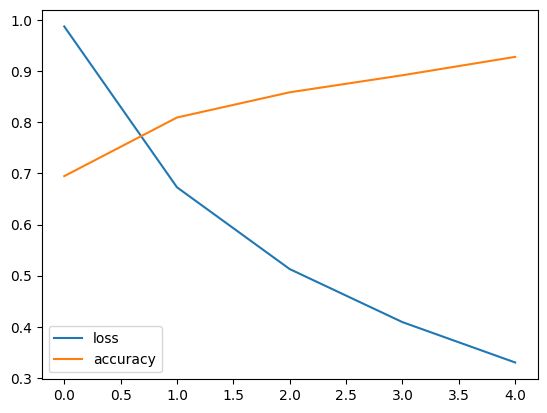

In [ ]:
pd.DataFrame(resnet_history.history).plot()

### Creating and testing EfficientNetB0 Feature Extraction model

In [ ]:
efficientnet_model = create_model(efficientnet_url, train_data.num_classes)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1280)              5919312   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [ ]:
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer="Adam",
                           metrics=["accuracy"])

In [ ]:
efficientnet_history = efficientnet_model.fit(train_data, epochs=5,
                       steps_per_epoch=len(train_data))

Epoch 1/5
24/24 [==============================] - 9s 81ms/step - loss: 1.9863 - accuracy: 0.3267
Epoch 2/5
24/24 [==============================] - 2s 84ms/step - loss: 1.3576 - accuracy: 0.6547
Epoch 3/5
24/24 [==============================] - 2s 85ms/step - loss: 1.0315 - accuracy: 0.7467
Epoch 4/5
24/24 [==============================] - 2s 87ms/step - loss: 0.8514 - accuracy: 0.7933
Epoch 5/5
24/24 [==============================] - 3s 116ms/step - loss: 0.7479 - accuracy: 0.8240


In [ ]:
# efficientnet_model.evaluate(test_data)

<Axes: >

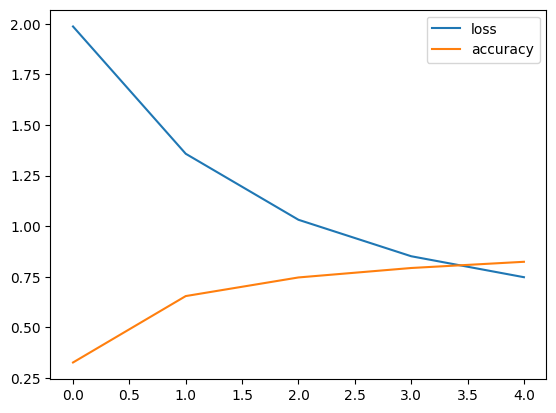

In [ ]:
pd.DataFrame(efficientnet_history.history).plot()

## Different types of Transfer Learning

* **"As is"** - use pretrained model on the native dataset
* **"Feature extraction"** - use pretrained model with your own dataset and output layer
* **"Fine-tuning"** - use pretrained model and change its layers and use it with your own dataset

In [ ]:
len(efficientnet_model.layers[0].weights)

359

### Comparing results using TensorBoard

* Cannot do that because of an error that I don't know how to fix